In [1]:
!pip install googletrans==3.1.0a0
!pip install --upgrade diffusers transformers -q


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=32797c8a52eccc7515c5aa40a67ff251dadade49312bc3568abf01f26008573c
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [2]:
from googletrans import Translator
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:

def get_translation(text,dest_lang):
  translator = Translator()
  translated_text = translator.translate(text, dest=dest_lang)
  return translated_text.text


In [4]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (900,900)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt3"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [5]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='your_hugging_face_auth_token', guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:269: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token', 'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image


  0%|          | 0/35 [00:00<?, ?it/s]

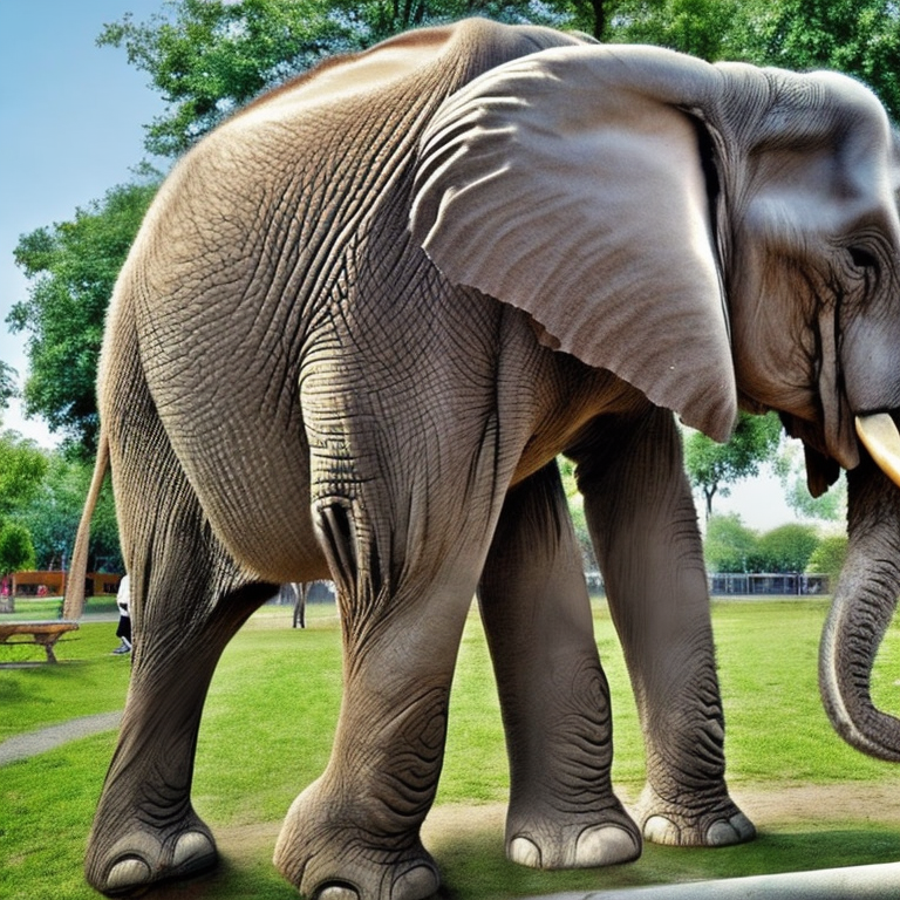

In [8]:
translation = get_translation("ஒரு பூங்காவில் யானை","en")
generate_image(translation, image_gen_model)